In [1]:
#generate location and reward data
import numpy as np
N_agents = 1
N_locations = 10
N_samples = 500000
p0 = np.arange(N_locations, dtype=float) + 1.0
sigma = 0.5*p0
locations_list = []
rewards_list = []
for idx in range(N_samples):
    locations = np.random.randint(0, N_locations, size=N_agents)
    l = p0[locations]
    s = sigma[locations]
    reward = np.random.normal(loc=l, scale=s).sum()
    locations_vector = np.zeros(N_locations, dtype=float)
    for loc in locations:
        locations_vector[loc] += 1.0
    locations_list += [locations_vector]
    rewards_list += [reward]
locations = np.array(locations_list)
rewards = np.array(rewards_list)
print locations[0:5]
print rewards[0:5]

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[ 3.46668485  0.45250563  2.28826062  0.33702931  1.6589068 ]


In [2]:
#test-train-validation split
rn_seed = 13
train_fraction = 0.67
from sklearn.model_selection import train_test_split
x_train, x_test_validate, y_train, y_test_validate = \
    train_test_split(locations, rewards, train_size=train_fraction, random_state=rn_seed)
x_test, x_validate, y_test, y_validate = \
    train_test_split(x_test_validate, y_test_validate, train_size=train_fraction, random_state=rn_seed)
print locations.shape
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape
print x_validate.shape, y_validate.shape

(1000000, 10)
(670000, 10) (670000,)
(221100, 10) (221100,)
(108900, 10) (108900,)


/Users/joe/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
#this helper function builds an MLP neural network
def mlp_model(N_inputs, layers):
    from keras.models import Sequential
    model = Sequential()
    from keras.layers import Dense
    N = layers[0]
    model.add(Dense(N, activation='elu', input_shape=(N_inputs,)))
    for N in layers[1:-1]:
        model.add(Dense(N, activation='elu'))
    N = layers[-1]
    model.add(Dense(N, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [4]:
#make MLP model
N_inputs = N_locations
N_outputs = 1
layers = [N_agents*N_locations, N_agents*N_locations/2, N_outputs]
print 'layers = ', layers
model = mlp_model(N_inputs, layers)
model.summary()

layers =  [10, 5, 1]


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


In [11]:
#train model to predict rewards
N_epochs = 100
batch_size = N_samples/5
model = mlp_model(N_inputs, layers)
fit_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=N_epochs, verbose=0, 
    validation_data=(x_validate, y_validate))

In [12]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

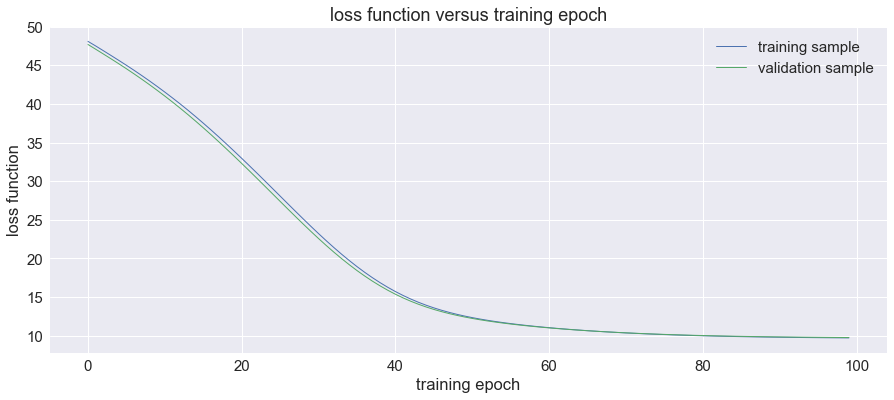

In [13]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, linewidth=1, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, linewidth=1, label='validation sample')
ax.set_title('loss function versus training epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()

In [14]:
#generate predictions dataframe
y_test_pred = model.predict(x_test)
import pandas as pd
cols = range(N_locations)
test = pd.DataFrame(x_test, columns=cols).astype(int)
test['y_test'] = y_test
test['y_test_pred'] = y_test_pred
test.head(10)

,0,1,2,3,4,5,6,7,8,9,y_test,y_test_pred
0,0,0,0,0,0,0,1,0,0,0,4.862805,7.080010
1,0,0,0,0,1,0,0,0,0,0,4.286970,5.214512
2,1,0,0,0,0,0,0,0,0,0,0.976208,1.006398
3,0,0,0,0,0,0,0,1,0,0,5.562329,8.214108
4,0,0,0,0,1,0,0,0,0,0,5.797715,5.214512
5,0,0,0,0,0,0,0,1,0,0,4.319221,8.214108
6,0,0,0,1,0,0,0,0,0,0,4.885417,4.037111
7,0,0,0,0,0,0,0,1,0,0,15.324516,8.214108
8,0,0,0,0,0,0,1,0,0,0,5.113881,7.080010
9,0,1,0,0,0,0,0,0,0,0,3.702895,1.996690


In [15]:
#show that the predicted value=mean of actuals
agg_dict = {'y_test':['count', 'mean', 'std'], 'y_test_pred':['mean']}
test_grouped = test.groupby(cols, as_index=False).agg(agg_dict)
test_grouped

0  1  2  3  4  5  6  7  8  9 y_test_pred y_test                     
                                       mean  count       mean       std
0  0  0  0  0  0  0  0  0  0  1    9.646011  22361  10.025303  5.046478
1  0  0  0  0  0  0  0  0  1  0    8.386435  21961   8.998672  4.512206
2  0  0  0  0  0  0  0  1  0  0    8.214108  22196   7.977901  3.941227
3  0  0  0  0  0  0  1  0  0  0    7.080010  22161   7.020892  3.490734
4  0  0  0  0  0  1  0  0  0  0    6.221353  22231   6.003940  3.003795
5  0  0  0  0  1  0  0  0  0  0    5.214512  22175   5.016136  2.506863
6  0  0  0  1  0  0  0  0  0  0    4.037111  22141   4.007756  1.997986
7  0  0  1  0  0  0  0  0  0  0    3.047489  21913   2.990443  1.499509
8  0  1  0  0  0  0  0  0  0  0    1.996690  22100   2.000193  0.997170
9  1  0  0  0  0  0  0  0  0  0    1.006398  21861   0.997075  0.497669

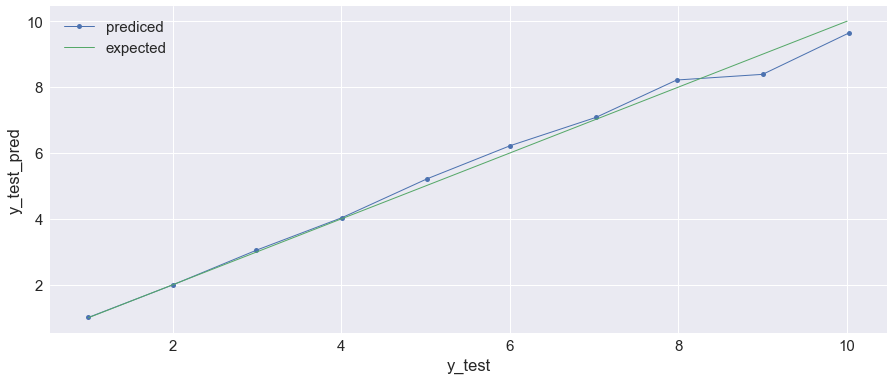

In [16]:
#plot loss vs training epoch
df = test_grouped
xp = df['y_test']['mean']
yp = df['y_test_pred']['mean']
fig, ax = plt.subplots(1,1, figsize=(15, 6))
p = ax.plot(xp, yp, marker='o', markersize=5, linewidth=1, label='prediced')
p = ax.plot(p0, p0, linewidth=1, label='expected')
p = ax.set_ylabel('y_test_pred')
p = ax.set_xlabel('y_test')
p = ax.legend()